# Full Photometry Pipeline

This tutorial demonstrates how to run the end--to--end photometry pipeline on
real JWST data included with *Mophongo*. We build templates from the F444W
mosaic and fit fluxes in the F770W image using spatially varying PSF
matching kernels.

## Detect sources in F444W

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits

data_dir = Path('../data')
field = data_dir / 'uds-test'
sci_444 = data_dir / f'{field}-f444w_sci.fits'
wht_444 = data_dir / f'{field}-f444w_wht.fits'


## Build PSF region map

/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


,geometry,psf_key_1,psf_key_2,psf_key
0,"POLYGON ((34.30361 -5.10681, 34.30431 -5.10875...",0,1,0
1,"POLYGON ((34.30556 -5.10681, 34.30583 -5.10736...",1,0,1
2,"POLYGON ((34.30361 -5.10681, 34.30472 -5.10681...",1,1,2
3,"POLYGON ((34.29764 -5.11472, 34.29764 -5.10681...",2,1,3
4,"POLYGON ((34.3025 -5.11042, 34.30361 -5.11292,...",3,1,4
5,"POLYGON ((34.30361 -5.11292, 34.30444 -5.11472...",4,1,5
6,"POLYGON ((34.30431 -5.10875, 34.30528 -5.11139...",5,1,6
7,"POLYGON ((34.30431 -5.11472, 34.30444 -5.11472...",6,1,7
8,"POLYGON ((34.30681 -5.11, 34.30806 -5.11333, 3...",7,0,8
9,"POLYGON ((34.30583 -5.11083, 34.30667 -5.11389...",7,1,9


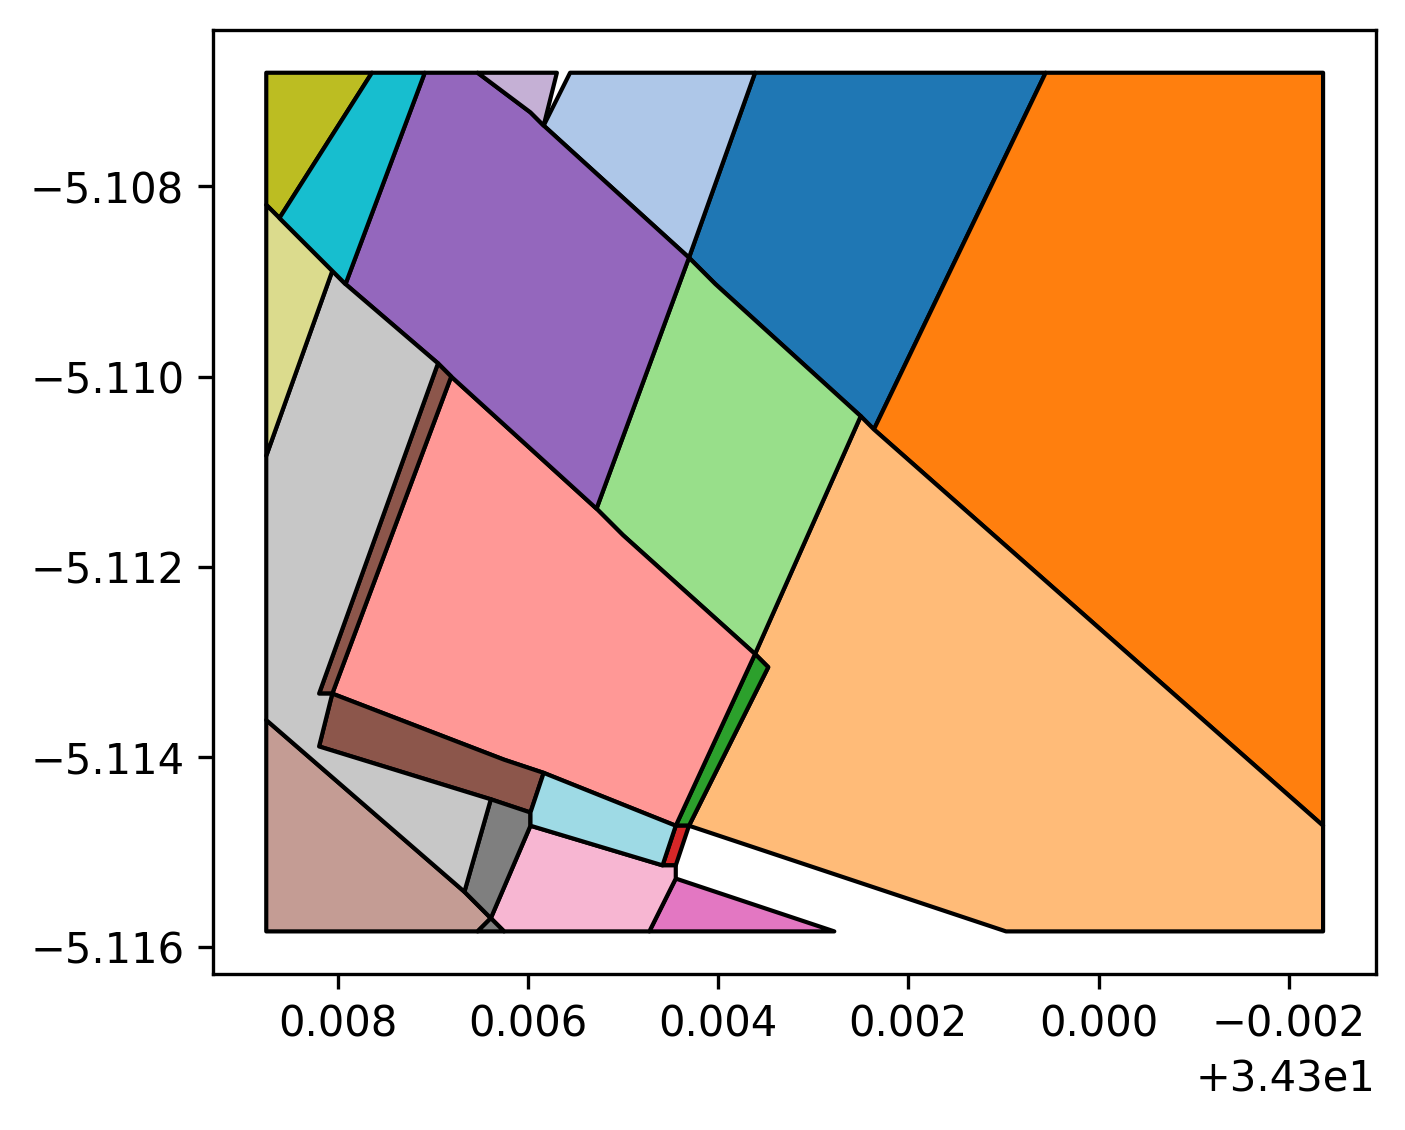

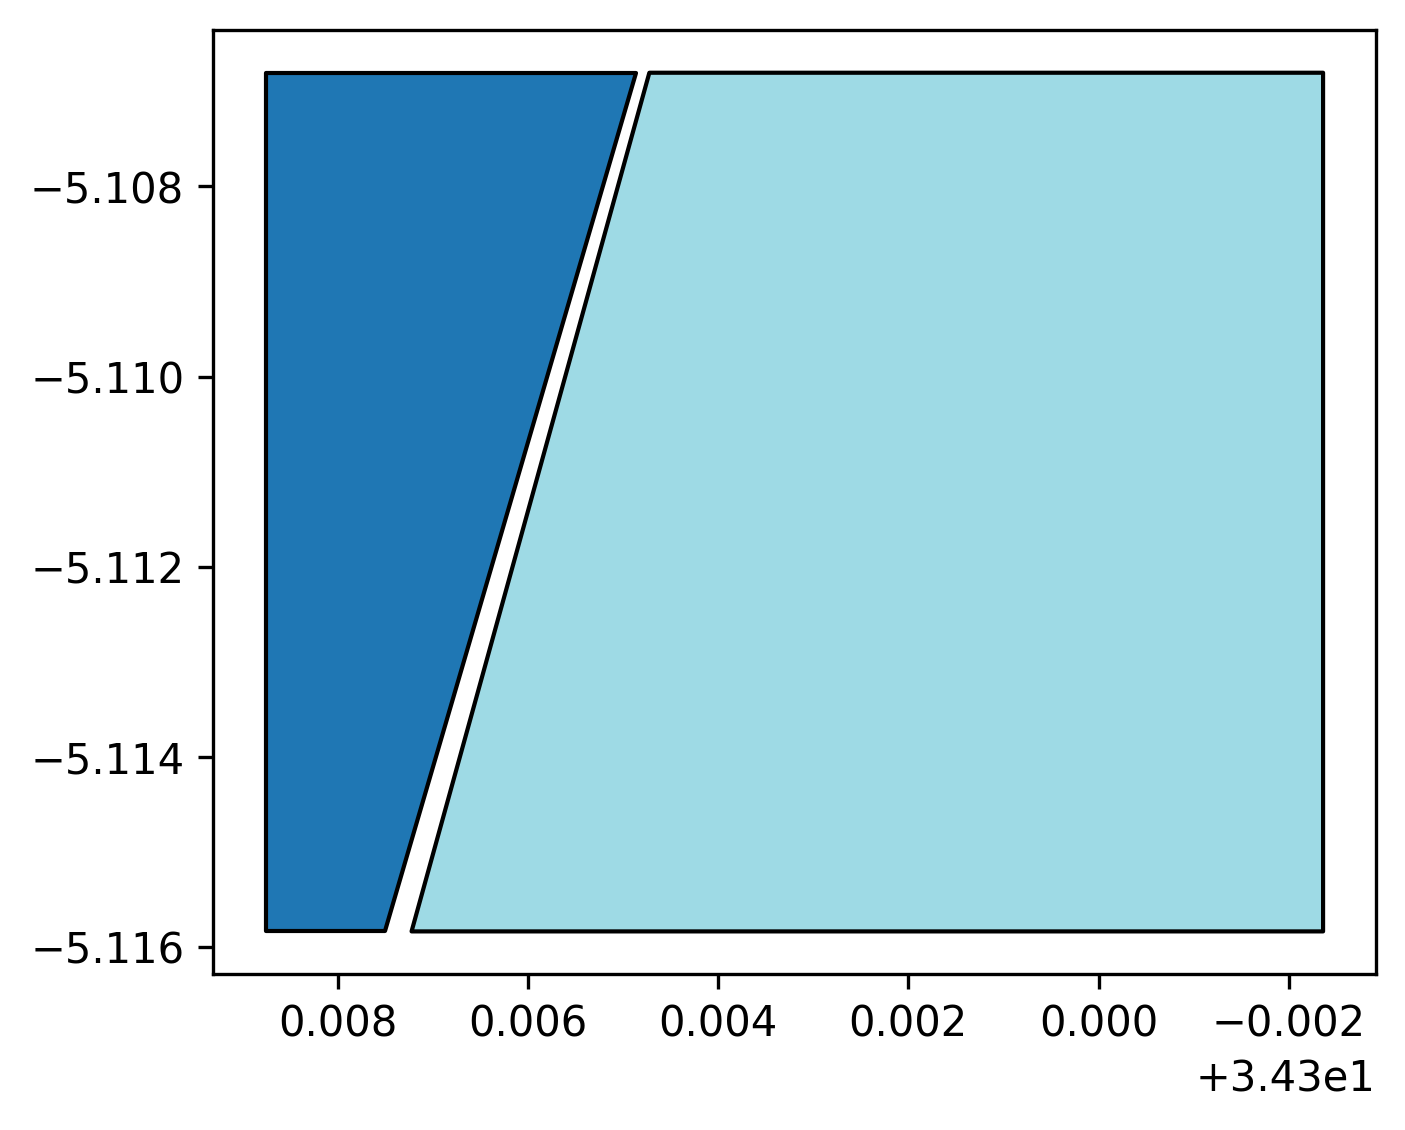

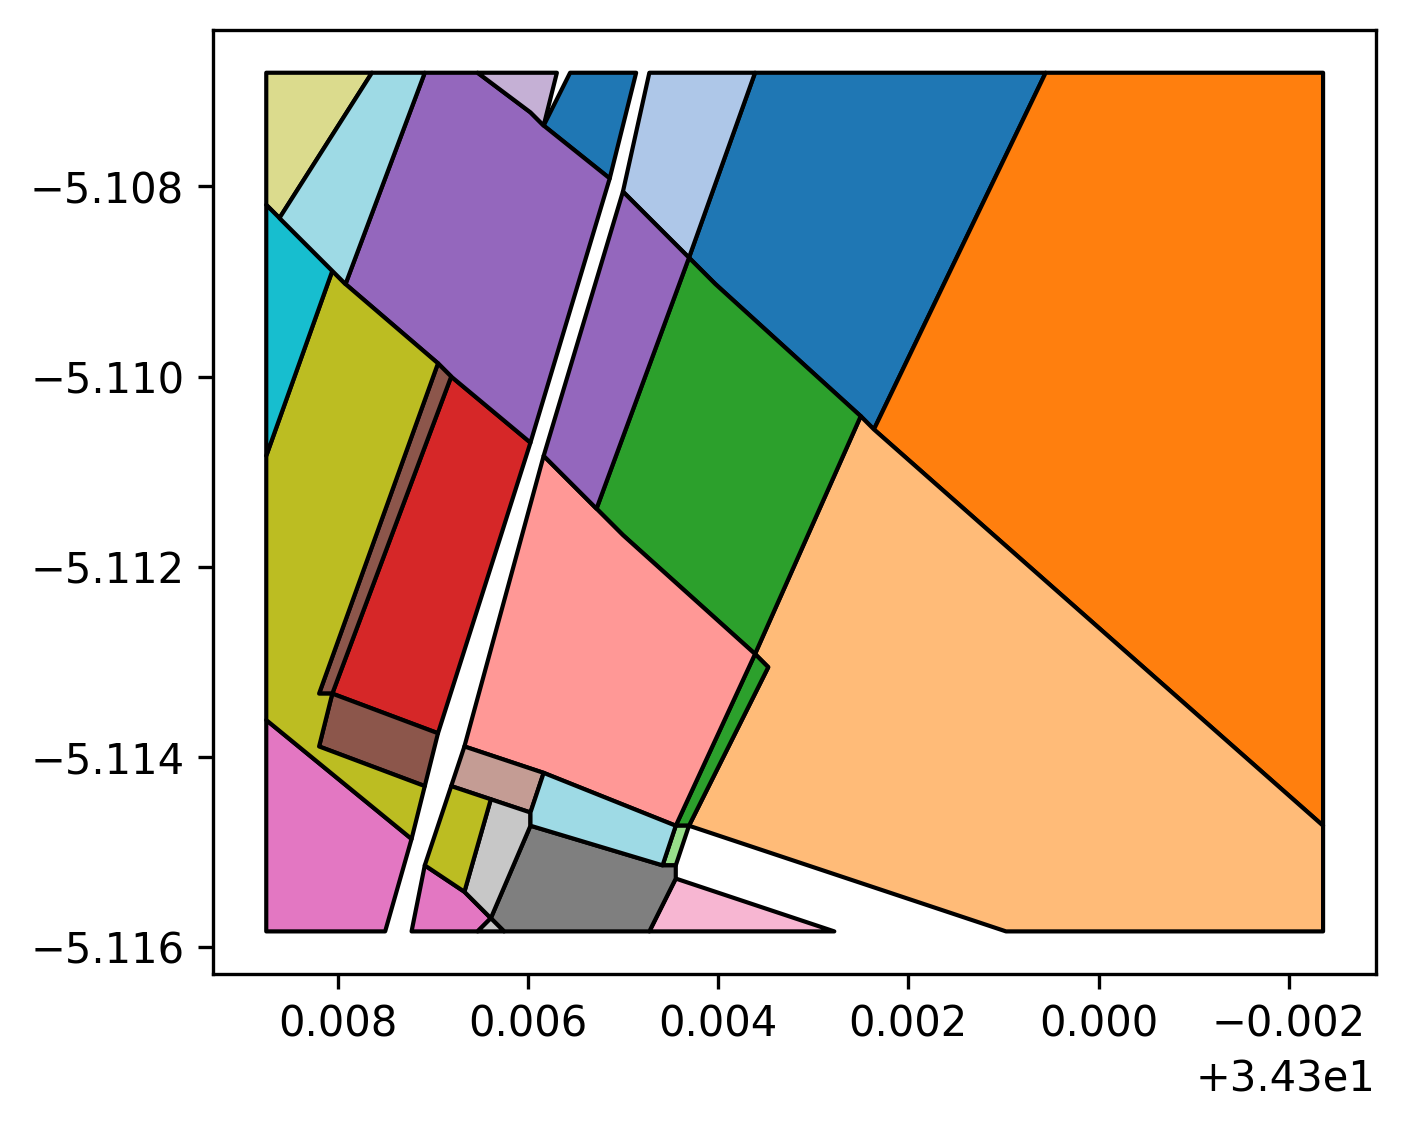

In [2]:
from mophongo.psf import DrizzlePSF
from mophongo.psf_map import PSFRegionMap

# also reads the associated _wcs.csv files
dpsf_444 = DrizzlePSF(driz_image=str(sci_444))
dpsf_770 = DrizzlePSF(driz_image=str(sci_444).replace('444', '770'))

# Keep only footprints overlapping the drizzled mosaic
prm_444 = PSFRegionMap.from_footprints(dpsf_444.footprint).overlay_with(dpsf_444.driz_footprint)
prm_770 = PSFRegionMap.from_footprints(dpsf_770.footprint).overlay_with(dpsf_444.driz_footprint)

# compute overlay regions unique to both PSFs
prm_kern = prm_444.overlay_with(prm_770)
prm_kern.name = '444 to 770 kernel'
prm_444.plot()
prm_770.plot()
prm_kern.plot()
prm_kern.regions

## Create PSF kernels

In [3]:
import mophongo.utils as utils

psf_dir = data_dir / 'PSF'
stpsf_444 = 'UDS_NRC.._F444W_OS4_GRID25'
stpsf_770 = 'UDS_MIRI_F770W_OS4_GRID9'
size = 201

# centroid positions of the regions 
pos = [np.squeeze(p.xy) for p in prm_kern.regions.geometry.centroid]

# load webb psfs
dpsf_444.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_444)
dpsf_770.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=stpsf_770)

# drizzle at centroid positions
prm_444.psfs = dpsf_444.get_psf_radec(pos, size=size)    
prm_770.psfs = dpsf_770.get_psf_radec(pos, size=size)    

# match kernels
kernels = [utils.matching_kernel(psf_444, psf_770, recenter=True) for psf_444, psf_770 in zip(prm_444.psfs, prm_770.psfs)]

prm_kern.psfs = np.asarray(kernels)
prm_kern.to_file(data_dir / f'{field}-f444w_kernel_f770w.geojson') 

## Run photometry

In [ ]:
from pathlib import Path
from astropy.io import fits
from mophongo.psf_map import PSFRegionMap

from mophongo.catalog import Catalog
from mophongo import pipeline

data_dir = Path('../data')
field = data_dir / 'uds-test'
sci_444 = data_dir / f'{field}-f444w_sci.fits'
wht_444 = data_dir / f'{field}-f444w_wht.fits'

prm_kern = PSFRegionMap.from_geojson(str(data_dir / f'{field}-f444w_kernel_f770w.geojson'))

# MIRI images
img_770 = fits.getdata(data_dir / f'{field}-f770w_sci.fits')
wht_770 = fits.getdata(data_dir / f'{field}-f770w_wht.fits')

# read in LW selected catalog
seg_LW = data_dir / f'{field}-LW_seg.fits'
cat444 = Catalog.from_fits(sci_444, wht_444, segmap=seg_LW, estimate_ivar=True)
cat770 = Catalog.from_fits(img_770, wht_770, segmap=seg_LW, estimate_ivar=True) 

# fitting photometry first image is template, 2nd and on the fitting images
table, resid, fitter = pipeline.run([cat444.sci, cat770.sci],
                                   cat444.segmap.data,
                                   catalog=cat444.table,
                                   weights=[cat444.ivar, cat770.ivar*1.2e6],
                                   kernels=[None, prm_kern],
                                   wcs=[cat444.wcs]* 2,
                                   fit_astrometry=True)
table.write('photometry.cat', format='ascii.commented_header', overwrite=True)


Measuring inverse variance map...
Measuring inverse variance map...


Extracting templates: 100%|██████████| 384/384 [00:00<00:00, 4783.43it/s]


Using kernel lookup table None


Convolving templates: 100%|██████████| 382/382 [00:03<00:00, 108.07it/s]


GlobalAstroFitter: 56 templates with S/N >= 10.0 used for astrometry
Building normal matrix...


Normal matrix: 100%|██████████| 718/718 [00:01<00:00, 509.69it/s]


Done...


In [2]:
fits.writeto('residual.fits',resid[0],overwrite=True)
fits.writeto('model.fits',img_770-resid[0],overwrite=True)


In [26]:
t = tmpls.templates[20]
t.shift
t.wcs 

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : np.float64(34.36555) np.float64(-5.2005) 
CRPIX : np.float64(-5610.5) np.float64(-7608.5) 
PC1_1 PC1_2  : np.float64(-1.1111111111111e-05) np.float64(0.0) 
PC2_1 PC2_2  : np.float64(0.0) np.float64(1.1111111111111e-05) 
CDELT : np.float64(1.0) np.float64(1.0) 
NAXIS : 208  210

In [23]:
cat770.wht

array([[47560888., 41501108., 45854244., ..., 69247640., 72572192.,
        74116592.],
       [44410604., 38499700., 43775756., ..., 68894296., 71073096.,
        70640320.],
       [53097244., 50817012., 54486756., ..., 69810720., 69894856.,
        67094608.],
       ...,
       [66982212., 70669744., 67458360., ..., 63931576., 67176344.,
        67501808.],
       [67679416., 69304840., 66918752., ..., 58712328., 65094164.,
        67780056.],
       [69233592., 68809536., 67567600., ..., 55017716., 62446140.,
        65614928.]], shape=(820, 1000), dtype='>f4')

In [18]:
pwd


'/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/examples'

In [4]:
np.sqrt(0)

NameError: name 'np' is not defined

In [5]:
import numpy as np
np.sqrt(0)

np.float64(0.0)